In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from scipy.stats import norm

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_context("notebook")
sns.set_theme(style="ticks", palette="muted")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.sankey import sankey
from src.comp_align import compare_SWalign

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /home/sulab/tRNA-charge-seq/projects/alignment-opti
Repo is in: /home/sulab/tRNA-charge-seq


# Analysis of the effect of alignment masking
This is a quick comparison between masked and unmasked alignment data.
For a more comprehensive comparison see the folder `masked-align_analysis`.


### Prepping the data

In [3]:
# Merge, annotate and filter data:
def prep_charge_df(plot_obj, sample_df, min_count=1000, agg='tr'):
    # Add E.coli control RPM to sample level information:
    ectr = plot_obj.charge_filt[agg][plot_obj.charge_filt[agg]['Ecoli_ctr']].copy()
    sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
    sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

    # Extract dataframe with charge and add sample information:
    charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order', 'RPM_Ectr']].merge(plot_obj.charge_filt[agg], on='sample_name_unique')

    if agg == 'tr':
        charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]
    elif agg == 'codon':
        charge_df['AA_codon'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['AA_codon'], charge_df['mito_codon'])]

    # Enforce minimum read count:
    # For each annotation, find samples
    # that have above the minimum count:
    if agg == 'tr':
        anno_col = 'tRNA_annotation'
    elif agg == 'aa':
        anno_col = 'amino_acid'
    else:
        anno_col = 'AA_codon'
        
    tann2snu = dict()
    for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                                    charge_df[anno_col], \
                                    charge_df['Ecoli_ctr'], \
                                    charge_df['count']):
        if ectr or cnt <= min_count:
            continue

        if tann in tann2snu:
            tann2snu[tann].add(snu)
        else:
            tann2snu[tann] = set()
            tann2snu[tann].add(snu)

    # Filter tRNA annotation based on
    # all samples having above the minimum count:
    all_snu = set(charge_df['sample_name_unique'])
    tann_sele = set()
    for tann in tann2snu:
        if tann2snu[tann] == all_snu:
            tann_sele.add(tann)
    mask = charge_df[anno_col].isin(tann_sele)
    filt_df = charge_df[mask].copy()
    filt_df['RPM_norm'] = filt_df['RPM'] / filt_df['RPM_Ectr']
    
    return(filt_df)

In [4]:
# Read the data:
sample_list_fnam = 'sample_list_alignment-opti.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Isolate the barcode test samples:
#mask = (sample_df['plot_group'] == 'Barcode test')
#sample_df = sample_df[mask].reset_index(drop=True).copy()

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='data/stats_collection/ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
tr_df = prep_charge_df(plot_obj, sample_df, min_count=1, agg='tr')
tr_df['Masked'] = False
cd_df = prep_charge_df(plot_obj, sample_df, min_count=1, agg='codon')
cd_df['Masked'] = False

# Get charge dataframe for aggregated stats (masked):
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='data/stats_collection_masked/ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
tr_df_masked = prep_charge_df(plot_obj, sample_df, min_count=1, agg='tr')
tr_df_masked['Masked'] = True
cd_df_masked = prep_charge_df(plot_obj, sample_df, min_count=1, agg='codon')
cd_df_masked['Masked'] = True

# Merge the two dataframes:
tr_dfm = tr_df.merge(tr_df_masked, on=['sample_name_unique', 'tRNA_anno_short'], suffixes=(None, '_masked'))
tr_dfc = pd.concat([tr_df, tr_df_masked])
cd_dfm = cd_df.merge(cd_df_masked, on=['sample_name_unique', 'AA_codon'], suffixes=(None, '_masked'))
cd_dfc = pd.concat([cd_df, cd_df_masked])

# Get dataframes aggregated over the replicates:
tr_dfm_agg = tr_dfm.groupby('tRNA_anno_short').agg(RPM_mean=('RPM', 'mean'), \
                                                   RPM_median=('RPM', 'median'), \
                                                   RPM_masked_mean=('RPM_masked', 'mean'), \
                                                   RPM_masked_median=('RPM_masked', 'median'), \
                                                   RPM_std=('RPM', 'std'), \
                                                   RPM_masked_std=('RPM_masked', 'std'), \
                                                   charge_mean=('charge', 'mean'), \
                                                   charge_median=('charge', 'median'), \
                                                   charge_masked_mean=('charge_masked', 'mean'), \
                                                   charge_masked_median=('charge_masked', 'median'), \
                                                   charge_std=('charge', 'std'), \
                                                   charge_masked_std=('charge_masked', 'std')).reset_index()

cd_dfm_agg = cd_dfm.groupby('AA_codon').agg(RPM_mean=('RPM', 'mean'), \
                                            RPM_median=('RPM', 'median'), \
                                            RPM_masked_mean=('RPM_masked', 'mean'), \
                                            RPM_masked_median=('RPM_masked', 'median'), \
                                            RPM_std=('RPM', 'std'), \
                                            RPM_masked_std=('RPM_masked', 'std'), \
                                            charge_mean=('charge', 'mean'), \
                                            charge_median=('charge', 'median'), \
                                            charge_masked_mean=('charge_masked', 'mean'), \
                                            charge_masked_median=('charge_masked', 'median'), \
                                            charge_std=('charge', 'std'), \
                                            charge_masked_std=('charge_masked', 'std')).reset_index()

Folder exists and overwrite set to false... Doing nothing.
Folder exists and overwrite set to false... Doing nothing.


### Plotting the differences

Below we will plot the differences in RPM and charge measurements.

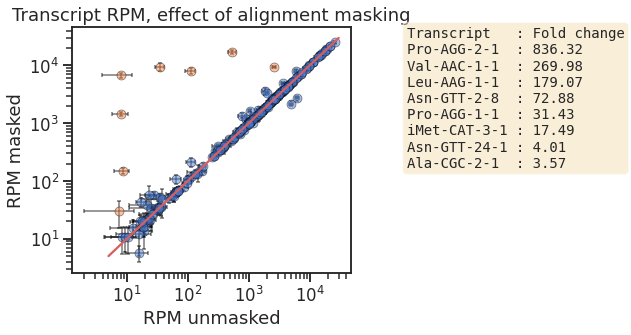

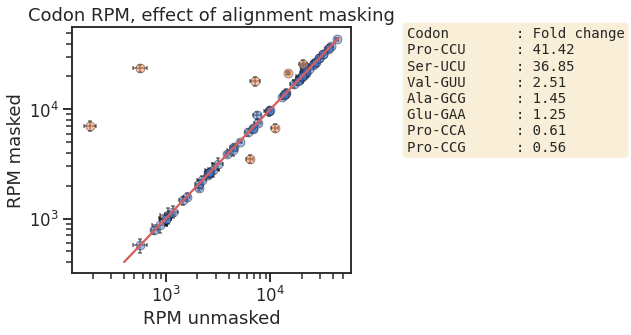

In [5]:
### RPM differences ###
with PdfPages('data/plotting/RPM_maskVSunmasked.pdf') as pp:
    # Plot the RPM repeatability per transcript
    # comparing masked vs. non-masked alignment.

    # Sort out the transcripts with high fold change:
    fold_mask = ((tr_dfm_agg['RPM_mean'] / tr_dfm_agg['RPM_masked_mean']) > 3) | \
                    ((tr_dfm_agg['RPM_masked_mean'] / tr_dfm_agg['RPM_mean']) > 3)
    min_mask = (tr_dfm_agg['RPM_mean'] > 10) | (tr_dfm_agg['RPM_masked_mean'] > 10)
    tr_dfm_agg['RPM_maskedVSunmasked'] = (tr_dfm_agg['RPM_masked_mean'] / tr_dfm_agg['RPM_mean'])
    fold_anno = tr_dfm_agg.loc[fold_mask&min_mask, ['tRNA_anno_short', 'RPM_maskedVSunmasked']].values

    # Plot:
    fig = plt.figure(figsize=(9, 5))
    gs = fig.add_gridspec(1, 5)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[0, 3:5])
    ax2.axis('off') # for textbox

    # Scatter for small fold change:
    g1 = sns.scatterplot(ax=ax1, data=tr_dfm_agg[(~fold_mask)&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('Transcript RPM, effect of alignment masking')
    g1.set(xlabel='RPM unmasked', ylabel='RPM masked')
    g1.set_yscale('log', base=10)
    g1.set_xscale('log', base=10)
    # Scatter for large fold change:
    g2 = sns.scatterplot(ax=ax1, data=tr_dfm_agg[fold_mask&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)

    # Errorbar for all datapoints:
    ax1.errorbar(tr_dfm_agg[min_mask]['RPM_mean'].values, \
                 tr_dfm_agg[min_mask]['RPM_masked_mean'].values, \
                 xerr=tr_dfm_agg[min_mask]['RPM_std'].values, \
                 yerr=tr_dfm_agg[min_mask]['RPM_masked_std'].values, \
                 fmt='none', capsize=2, zorder=1, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
    ax1.plot([5, 30000], [5, 30000], c='r', zorder=10)

    # Make textbox for transcripts 
    # with >100% fold change:
    txt_list = list()
    # print('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    txt_list.append('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    for tr_tup in sorted(fold_anno, key=lambda x: x[1], reverse=True):
        # print('{:<13}: {:.2f}'.format(*tr_tup))
        txt_list.append('{:<13}: {:.2f}'.format(*tr_tup))
    anno_str = '\n'.join(txt_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.2, 1, anno_str, transform=ax2.transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontfamily='monospace')

    fig.tight_layout()
    # fig.savefig('data/plotting/tr_RPM_maskVSunmasked.pdf', bbox_inches='tight')
    pp.savefig(fig, bbox_inches='tight')
    
    
    # Plot the RPM repeatability per codon
    # comparing masked vs. non-masked alignment.

    # Sort out the codons with high fold change:
    fold_mask = ((cd_dfm_agg['RPM_mean'] / cd_dfm_agg['RPM_masked_mean']) > 1.2) | \
                    ((cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean']) > 1.2)
    min_mask = (cd_dfm_agg['RPM_mean'] > 100) | (cd_dfm_agg['RPM_masked_mean'] > 100)
    cd_dfm_agg['RPM_maskedVSunmasked'] = (cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean'])
    fold_anno = cd_dfm_agg.loc[fold_mask&min_mask, ['AA_codon', 'RPM_maskedVSunmasked']].values

    # Plot:
    fig = plt.figure(figsize=(9, 5))
    gs = fig.add_gridspec(1, 5)
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[0, 3:5])
    ax2.axis('off') # for textbox

    # Scatter for small fold change:
    g1 = sns.scatterplot(ax=ax1, data=cd_dfm_agg[(~fold_mask)&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('Codon RPM, effect of alignment masking')
    g1.set(xlabel='RPM unmasked', ylabel='RPM masked')
    g1.set_yscale('log', base=10)
    g1.set_xscale('log', base=10)
    # Scatter for large fold change:
    g2 = sns.scatterplot(ax=ax1, data=cd_dfm_agg[fold_mask&min_mask], x='RPM_mean', y='RPM_masked_mean', \
                         zorder=5, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)

    # Errorbar for all datapoints:
    ax1.errorbar(cd_dfm_agg[min_mask]['RPM_mean'].values, \
                 cd_dfm_agg[min_mask]['RPM_masked_mean'].values, \
                 xerr=cd_dfm_agg[min_mask]['RPM_std'].values, \
                 yerr=cd_dfm_agg[min_mask]['RPM_masked_std'].values, \
                 fmt='none', capsize=2, zorder=1, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
    ax1.plot([400, 45000], [400, 45000], c='r', zorder=10)

    # Make textbox for codons 
    # with >50% fold change:
    txt_list = list()
    # print('{:<13}: {}'.format(*['Transcript', 'Fold change']))
    txt_list.append('{:<13}: {}'.format(*['Codon', 'Fold change']))
    for cd_tup in sorted(fold_anno, key=lambda x: x[1], reverse=True):
        # print('{:<13}: {:.2f}'.format(*cd_tup))
        txt_list.append('{:<13}: {:.2f}'.format(*cd_tup))
    anno_str = '\n'.join(txt_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.2, 1, anno_str, transform=ax2.transAxes, fontsize=14,
             verticalalignment='top', bbox=props, fontfamily='monospace')

    fig.tight_layout()
    #fig.savefig('data/plotting/cd_RPM_maskVSunmasked.pdf', bbox_inches='tight')
    pp.savefig(fig, bbox_inches='tight')

In [6]:
fold_mask = ((tr_dfm_agg['RPM_mean'] / tr_dfm_agg['RPM_masked_mean']) > 3) | \
                ((tr_dfm_agg['RPM_masked_mean'] / tr_dfm_agg['RPM_mean']) > 3)
min_mask = (tr_dfm_agg['RPM_mean'] > 10) | (tr_dfm_agg['RPM_masked_mean'] > 10)
tr_dfm_agg['RPM_maskedVSunmasked'] = (tr_dfm_agg['RPM_masked_mean'] / tr_dfm_agg['RPM_mean'])
fold_anno = tr_dfm_agg.loc[fold_mask&min_mask, ['tRNA_anno_short', 'RPM_maskedVSunmasked']].values


In [7]:
fold_anno

array([['Ala-CGC-2-1', 3.5707945662766907],
       ['Asn-GTT-2-8', 72.87552989909616],
       ['Asn-GTT-24-1', 4.006497734090907],
       ['Leu-AAG-1-1', 179.0689188319387],
       ['Pro-AGG-1-1', 31.427396695497123],
       ['Pro-AGG-2-1', 836.3193001139558],
       ['Val-AAC-1-1', 269.98378703631664],
       ['iMet-CAT-3-1', 17.49426257765479]], dtype=object)

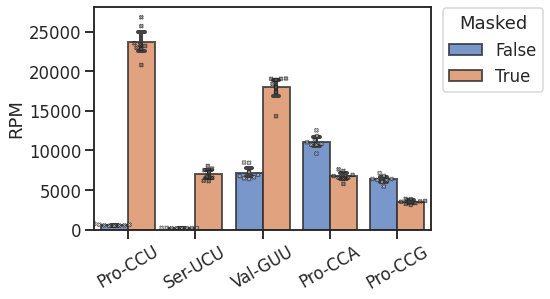

In [8]:
# Sort out the codons with high fold change
# and pick out those with >50% fold change:
fold_mask = ((cd_dfm_agg['RPM_mean'] / cd_dfm_agg['RPM_masked_mean']) > 1.5) | \
                ((cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean']) > 1.5)
min_mask = (cd_dfm_agg['RPM_mean'] > 100) | (cd_dfm_agg['RPM_masked_mean'] > 100)
cd_dfm_agg['RPM_maskedVSunmasked'] = (cd_dfm_agg['RPM_masked_mean'] / cd_dfm_agg['RPM_mean'])
fold_anno = cd_dfm_agg.loc[fold_mask&min_mask, ['AA_codon', 'RPM_maskedVSunmasked']].values
anno_order = [t[0] for t in sorted(fold_anno, key=lambda x: x[1], reverse=True)]

# Plot the chosen codons:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))
mask = (cd_dfc['AA_codon'].isin(anno_order))

g1 = sns.barplot(ax=ax1, data=cd_dfc[mask], y='RPM', x='AA_codon', hue='Masked', \
                 order=anno_order, capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                 zorder=1)
g1 = sns.swarmplot(ax=ax1, data=cd_dfc[mask], y='RPM', x='AA_codon', hue='Masked', \
                   dodge=True, order=anno_order, \
                   palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                   size=4, marker="X", legend=False, \
                   zorder=2)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
g1.set(xlabel='')
fig.tight_layout()

fig.savefig('data/plotting/Ser-Pro_codons_RPM-change.pdf', bbox_inches='tight')

In [9]:
# Collect annotation comparison data:
snu_lst= list(set(sample_df['sample_name_unique']))
data_dir = '{}/data'.format(NBdir)
anno_df, codon_df = compare_SWalign(snu_lst, data_dir, \
                                    aln_dir1='SWalign', aln_dir2='SWalign_masked')

Now processing sample: 32m_1  40h_1  4h_1  8h_1  8m_1  16h_1  0m_1  1h_1 

In [10]:
codon_df.head(3)

,codon1,codon2,count_c1_tot,count_c2_tot,count
0,Ala-AGC,Ala-AGC,78046,78418,77903
1,Ala-AGC,Ala-AGC@Ala-CGC,78046,79,6
2,Ala-AGC,Ala-AGC@Ala-CGC@Ala-TGC,78046,104,4


In [11]:
# Select codons with the largest difference
new_codon = [set(a1.split('@')) != set(a2.split('@')) for a1, a2 in zip(codon_df['codon1'], codon_df['codon2'])]
mask = np.array(new_codon)

top_series = codon_df[mask]['count'].sort_values(ascending=False).head(15).reset_index()
top_codon_df = codon_df.loc[top_series['index'].values, :]

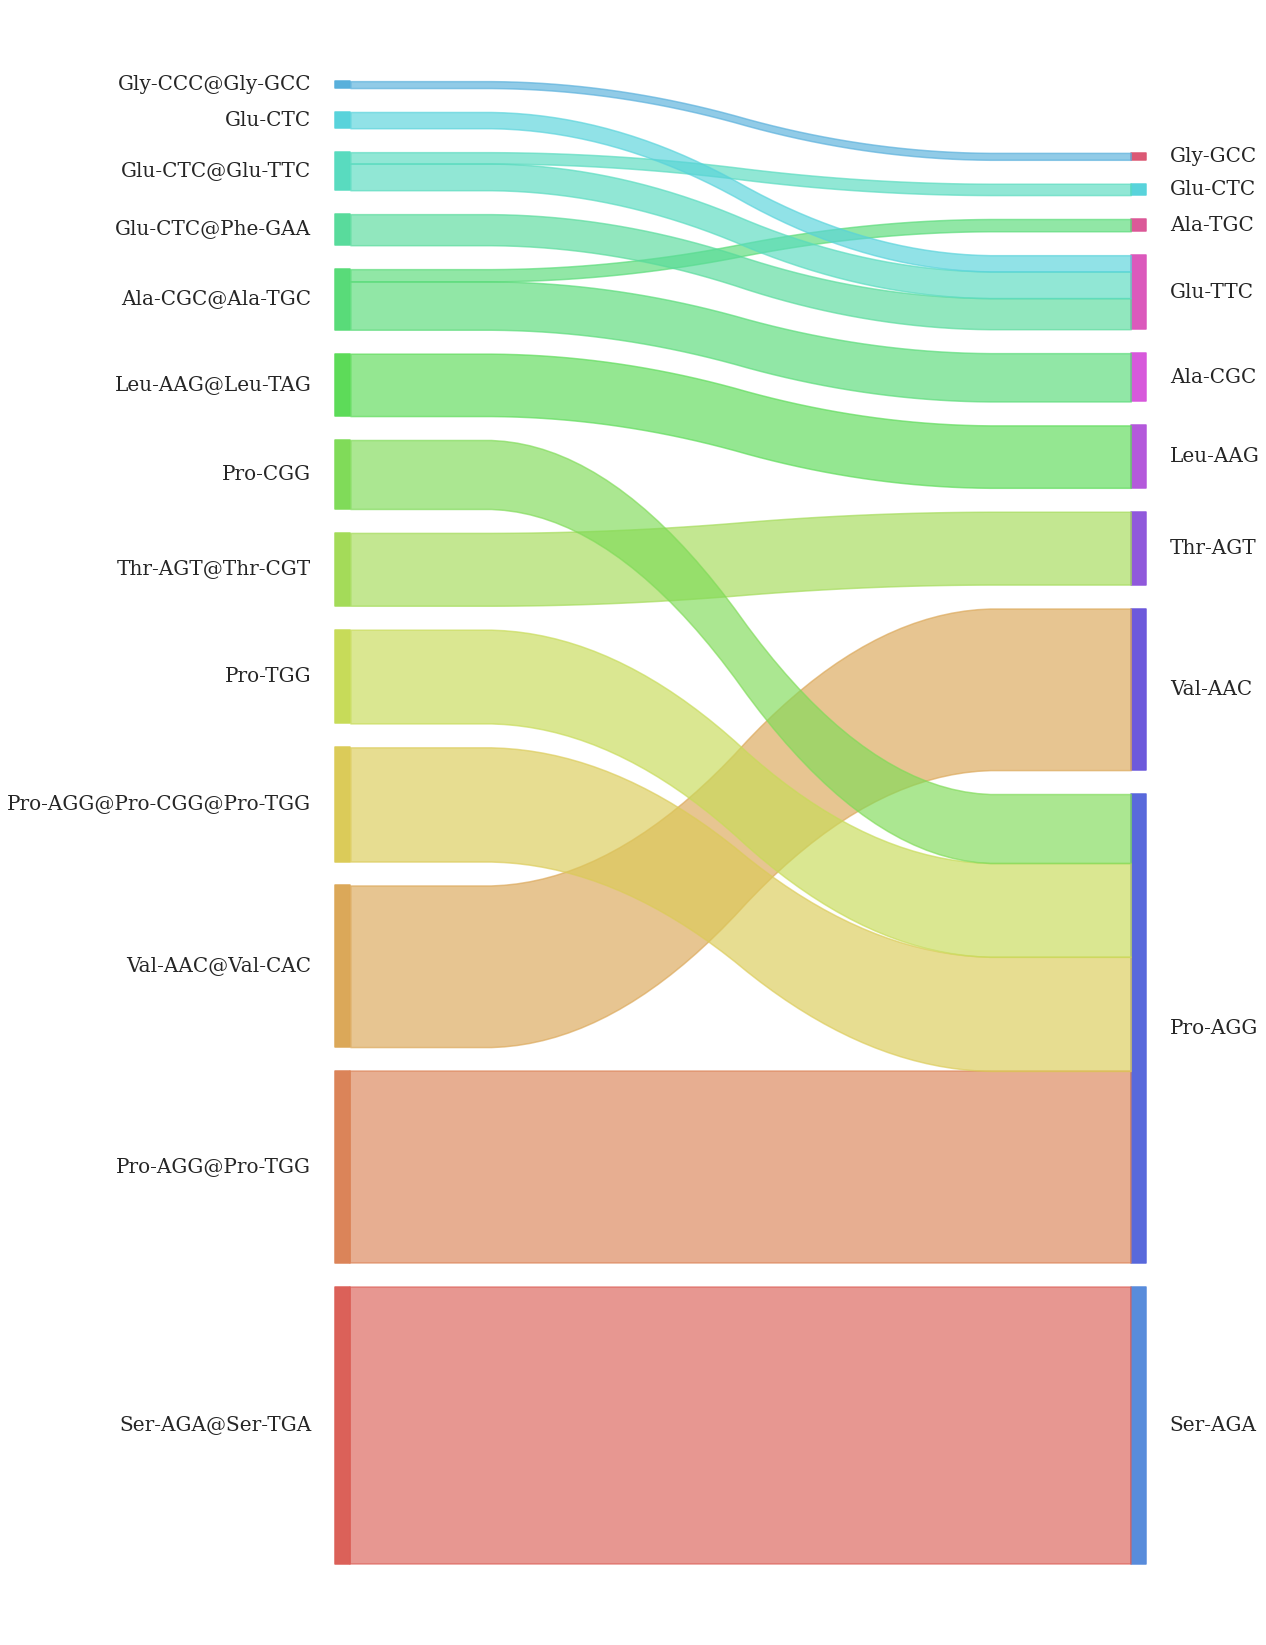

In [12]:
# Plot the codon annotation migration:
sankey(
    left=top_codon_df['codon1'], right=top_codon_df['codon2'], \
    leftWeight=top_codon_df['count'].values, rightWeight=top_codon_df['count'].values,\
    aspect=10, fontsize=20, figure_name="data/plotting/codon-annotation-flow"
)